_Lambda School Data Science, Unit 2_
 
# Sprint Challenge: Predict Steph Curry's shots 🏀

For your Sprint Challenge, you'll use a dataset with all Steph Curry's NBA field goal attempts. (Regular season and playoff games, from October 28, 2009, through June 5, 2019.) 

You'll use information about the shot and the game to predict whether the shot was made. This is hard to predict! Try for an accuracy score in the high 50's or low 60's. The dataset was collected with the [nba_api](https://github.com/swar/nba_api) Python library.

In [2]:
import pandas as pd
url = 'https://drive.google.com/uc?export=download&id=1fL7KPyxgGYfQDsuJoBWHIWwCAf-HTFpX'
df = pd.read_csv(url, parse_dates=['game_date']).set_index('game_date')
assert df.shape == (13958, 19)

This Sprint Challenge has two parts. To demonstrate mastery on each part, do all the required, numbered instructions. To earn a score of "3" for the part, also do the stretch goals.

## Part 1. Prepare to model

### Required

1. **Do train/validate/test split.** Use the 2009-10 season through 2016-17 season to train, the 2017-18 season to validate, and the 2018-19 season to test. NBA seasons begin in October and end in June. You'll know you've split the data correctly when your train set has 11081 observations, your validation set has 1168 observations, and your test set has 1709 observations.

In [3]:
df['year'] = df.index.year
df['month'] = df.index.month

early_2017 = (df['year'] == 2017) & (df['month'] < 7)
late_2017 = (df['year'] == 2017) & (df['month'] >= 7)
early_2018 = (df['year'] == 2018) & (df['month'] < 7)
late_2018 = (df['year'] == 2018) & (df['month'] >= 7)

train_condition = (df['year'] <= 2016) | (early_2017)

val_condition = (late_2017) | (early_2018)
test_condition = (late_2018) | (df['year'] > 2018)

train = df[train_condition].copy()
val = df[val_condition].copy()
test = df[test_condition].copy()

train.shape, val.shape, test.shape

((11081, 21), (1168, 21), (1709, 21))

2. **Begin with baselines for classification.** Your target to predict is `shot_made_flag`. What is the baseline accuracy for the validation set, if you guessed the majority class for every prediction?

In [4]:
target = 'shot_made_flag'

train[target].value_counts()

0    5842
1    5239
Name: shot_made_flag, dtype: int64

In [5]:
from sklearn.metrics import accuracy_score as acc
val['baseline'] = 0

acc(val['baseline'], val[target])

0.5162671232876712

3. **Use Ordinal Encoding _or_ One-Hot Encoding,** for the categorical features you select.

In [6]:
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder

def pre_processing(train, val, test):
    pipeline = make_pipeline(OrdinalEncoder())
    pipeline.fit(train)
    
    x_train = pd.DataFrame(pipeline.transform(train))
    x_train.columns = train.columns
   
    x_val = pd.DataFrame(pipeline.transform(val))
    x_val.columns = val.columns
    
    x_test = pd.DataFrame(pipeline.transform(test))
    x_test.columns = test.columns
    
    return x_train, x_val, x_test

4. **Train a Random Forest _or_ Logistic Regression** with the features you select.

In [7]:
from sklearn.ensemble import RandomForestClassifier

drop_these = ['year', target]
features = test.drop(columns=drop_these).columns

pp_train, pp_val, pp_test = pre_processing(train[features], val[features], test[features])

model = RandomForestClassifier(n_estimators = 20)
model.fit(pp_train, train[target])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

### Stretch goals
Engineer at least 4 of these 5 features:

- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
- **Opponent**: Who is the other team playing the Golden State Warriors?
- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
- **Made previous shot**: Was Steph Curry's previous shot successful?
    

In [26]:
df.columns
df['Homecourt_Advantage']= df['htm'] == 'GSW'
df['Opponenet'] = df['htm'].replace('GSW', '') + df['vtm'].replace('GSW', '')
df['seconds_remaining_in_per'] = df['minutes_remaining'] * 60 + df['seconds_remaining']
df['seconds_remaining_in_game'] = (4 - df['period']) * 12 * 60 + df['seconds_remaining_in_per']

df['not_first_shot'] = df.shift(1)['game_id'] == df['game_id']
df['previous_shot_made'] = df.shift(-1)[target].astype(bool)
df['previous_shot_made_corr'] = (df['not_first_shot']) & (df['previous_shot_made'])

In [31]:
early_2017 = (df['year'] == 2017) & (df['month'] < 7)
late_2017 = (df['year'] == 2017) & (df['month'] >= 7)
early_2018 = (df['year'] == 2018) & (df['month'] < 7)
late_2018 = (df['year'] == 2018) & (df['month'] >= 7)

train_condition = (df['year'] <= 2016) | (early_2017)

val_condition = (late_2017) | (early_2018)
test_condition = (late_2018) | (df['year'] > 2018)

train = df[train_condition].copy()
val = df[val_condition].copy()
test = df[test_condition].copy()

drop_these = ['not_first_shot', 'previous_shot_made', 'year', target]
features = test.drop(columns=drop_these).columns

pp_train, pp_val, pp_test = pre_processing(train[features], val[features], test[features])

model = RandomForestClassifier(n_estimators = 1000)
model.fit(pp_train, train[target])

pp_train.columns

Index(['game_id', 'game_event_id', 'player_name', 'period',
       'minutes_remaining', 'seconds_remaining', 'action_type', 'shot_type',
       'shot_zone_basic', 'shot_zone_area', 'shot_zone_range', 'shot_distance',
       'loc_x', 'loc_y', 'htm', 'vtm', 'season_type',
       'scoremargin_before_shot', 'month', 'Homecourt_Advantage', 'Opponenet',
       'seconds_remaining_in_per', 'seconds_remaining_in_game',
       'previous_shot_made_corr'],
      dtype='object')

## Part 2. Evaluate models

### Required
1. Get your model's **validation accuracy.** (Multiple times if you try multiple iterations.)

In [33]:
acc(val[target],model.predict(pp_val))

0.6018835616438356

In [35]:
features = ['previous_shot_made_corr', 'seconds_remaining_in_game','seconds_remaining_in_per',
            'Opponenet', 'Homecourt_Advantage', 'month', 'scoremargin_before_shot',
            'season_type', 'action_type', 'shot_type',
            'shot_zone_basic', 'shot_zone_area', 'shot_zone_range', 'shot_distance',
            'loc_x', 'loc_y', 'period'
           ]

pp_train, pp_val, pp_test = pre_processing(train[features], val[features], test[features])

model = RandomForestClassifier(n_estimators = 1000)
model.fit(pp_train, train[target])

acc(val[target],model.predict(pp_val))

0.598458904109589

2. Get your model's **test accuracy.** (One time, at the end.)

In [36]:
drop_these = ['not_first_shot', 'previous_shot_made', 'year', target]
features = test.drop(columns=drop_these).columns

pp_train, pp_val, pp_test = pre_processing(train[features], val[features], test[features])

model = RandomForestClassifier(n_estimators = 1000)
model.fit(pp_train, train[target])

acc(test[target],model.predict(pp_test))

0.6307782328847279

3. Get and plot your Random Forest's **feature importances** _or_ your Logistic Regression's **coefficients.**

<BarContainer object of 24 artists>

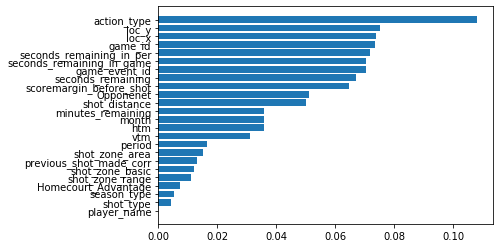

In [72]:
from matplotlib import pyplot as plt

feature_importance = pd.DataFrame({'features':pp_train.columns, 'importance':model.feature_importances_})
f_im = feature_importance.sort_values(by=['importance'], ascending=True).set_index(['features'])

plt.barh(f_im.index, f_im['importance'])

4. Imagine this is the confusion matrix for a binary classification model. **Calculate accuracy, precision, and recall for this confusion matrix:**

<table>
  <tr>
    <td colspan="2" rowspan="2"></td>
    <td colspan="2">Predicted</td>
  </tr>
  <tr>
    <td>Negative</td>
    <td>Positive</td>
  </tr>
  <tr>
    <td rowspan="2">Actual</td>
    <td>Negative</td>
    <td style="border: solid">85</td>
    <td style="border: solid">58</td>
  </tr>
  <tr>
    <td>Positive</td>
    <td style="border: solid">8</td>
    <td style="border: solid"> 36</td>
  </tr>
</table>

In [86]:
Ac_neg = 85 + 58
Ac_pos = 8 + 36
Pr_neg = 85 + 8
Pr_pos = 58 + 36

False_pos = 58
True_pos = 36
False_neg = 8
True_neg = 85

Accuracy = True_pos + True_neg / Ac_neg + Ac_pos
Precision = True_pos / Pr_pos
Recall = True_pos / Ac_pos

Accuracy, Precision, Recall

(80.5944055944056, 0.3829787234042553, 0.8181818181818182)

### Stretch goals
- Calculate F1 score for the provided, imaginary confusion matrix.

In [91]:
F1 = 2 * Precision * Recall / (Precision + Recall)
F1

0.5217391304347826

- Plot a real confusion matrix for your basketball model, with row and column labels.

In [114]:
from sklearn.metrics import confusion_matrix, classification_report

labels = test[target].unique()
columns = [f'Predicted {label}' for label in labels]
index = [f'Actual {label}' for label in labels]
pd.DataFrame(confusion_matrix(test[target],model.predict(pp_test)), columns=columns, index=index)

,Predicted 1,Predicted 0
Actual 1,605,307
Actual 0,324,473


- Print the classification report for your model.

In [119]:
print(classification_report(test[target],model.predict(pp_test)))

              precision    recall  f1-score   support

           0       0.65      0.66      0.66       912
           1       0.61      0.59      0.60       797

    accuracy                           0.63      1709
   macro avg       0.63      0.63      0.63      1709
weighted avg       0.63      0.63      0.63      1709

